In [1]:
import sys

PWD = '../..'
sys.path.append(PWD)

DATASET_PATH = '../../data/dataset/dataset.pkl'

from joblib import Parallel, delayed

import pickle
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from src.cfd import CFD
from src.gauss_hist import plot_diff_hist_stats, get_gauss_stats
from src.network_utils import train_model as _base_train_model, plot_history

In [2]:
N_JOBS = 8

DATASET_PATH = '../../data/dataset/dataset.pkl'

PLANE = 2
CHANNEL = 11

PRINT_PCOV = True

In [3]:
with open(DATASET_PATH, 'rb') as file:
    dataset = pickle.load(file)
    
all_X, all_y = dataset[(PLANE, CHANNEL)][0], dataset[(PLANE, CHANNEL)][1]
all_X.shape, all_y.shape

((26187, 24), (26187,))

In [4]:
x_time = np.arange(0, 24 / 7.695, 1 / 7.695)
x_time.shape

(24,)

# Preprocess

In [5]:
N_BASELINE = 8

In [6]:
# turns out the networks do better without the normalisation, CFD has to use normalised waveforms anyway
# all_X -= np.mean(all_X[:, :N_BASELINE], axis=1)[:, None]
# all_X /= all_X.max(axis=1)[:, None]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19640, 24), (6547, 24), (19640,), (6547,))

# Utils

In [8]:
def plot_difference_hist(y_true, y_pred, plane, channel, hist_range=(-0.5, 0.5), n_bins=100, show=True, print_pcov=False):
    mu, std, pcov, fwhm = plot_diff_hist_stats(y_true, y_pred, show=False, n_bins=n_bins, hist_range=hist_range, plot_gauss=True, plot_fwhm=True)

    plt.title(f'Diff histogram (p: {plane}, ch: {channel}), mean={mu:0.4f}, std={std:0.4f}')
    if show:
        plt.show()
    if print_pcov:
        print('Covariance matrix of the Gaussian fit:')
        print(pcov)

    return std, pcov, fwhm

def train_model(model, name, X_train=X_train, y_train=y_train, X_val=X_test, y_val=y_test, lr=0.001, train=False, n_epochs=1000, verbose=1, batch_size=2048, lr_patience=None, es_patience=None, loss_weights=None):
    return _base_train_model(model, name, 'basic_tests', X_train, y_train, X_val, y_val, lr, train, n_epochs, verbose, batch_size, lr_patience, es_patience, loss_weights)

# CFD

In [9]:
def compute_cfd_resolution(threshold):
    print(f'Processing threshold={threshold:0.2f}...')
    cfd = CFD(n_baseline=N_BASELINE, threshold=threshold)
    
    y_pred = []
    for x in X_train:
        y_pred.append(cfd.predict(x_time, x))
        
    y_pred = np.array(y_pred)
    std_cfd, _, _ = plot_difference_hist(y_train, y_pred, PLANE, CHANNEL, show=False)
    std_stat_cfd = np.std(y_pred - y_train)
    max_diff = max(abs(y_pred - y_train))
    
    return threshold, std_cfd, std_stat_cfd, max_diff

In [10]:
thresholds = np.arange(0.12, 0.27, 0.005)
cfd_all_stds = Parallel(n_jobs=N_JOBS)(delayed(compute_cfd_resolution)(threshold) for threshold in thresholds)

In [11]:
cfd_stds = {key: v for key, v, _, _ in cfd_all_stds}
cfd_stat_stds = {key: v for key, _, v, _ in cfd_all_stds}
cfd_max_diffs = {key: v for key, _, _, v in cfd_all_stds}

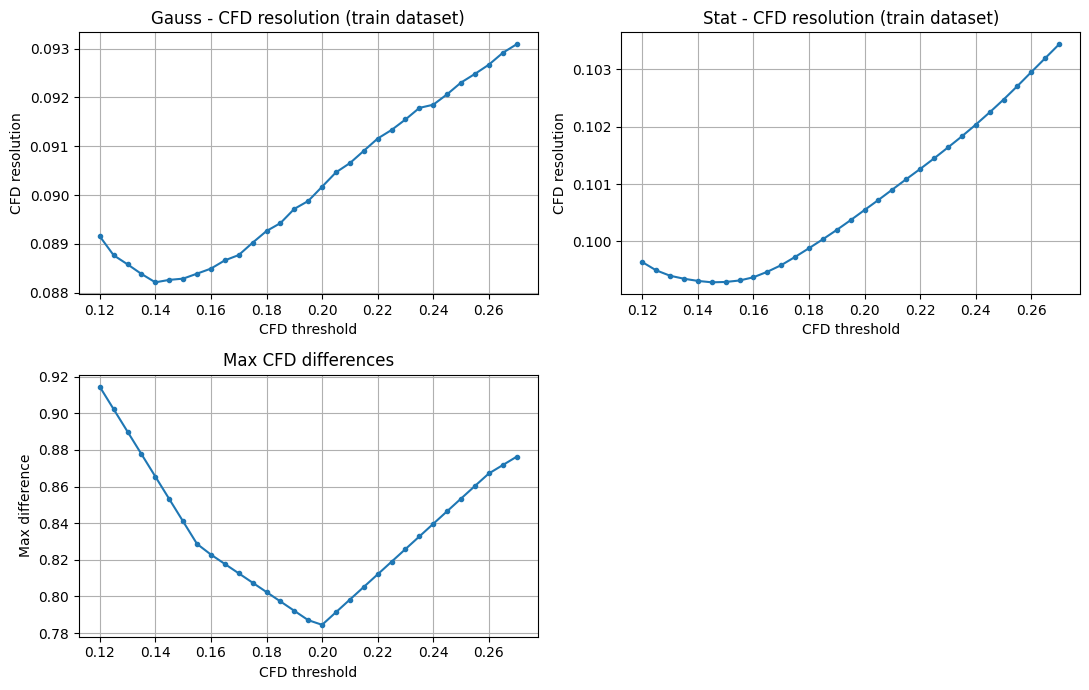

In [12]:
plt.figure(figsize=(11, 7))

plt.subplot(2, 2, 1)
plt.plot(cfd_stds.keys(), cfd_stds.values(), marker='.')
plt.title('Gauss - CFD resolution (train dataset)')
plt.xlabel('CFD threshold')
plt.ylabel('CFD resolution')
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(cfd_stat_stds.keys(), cfd_stat_stds.values(), marker='.')
plt.title('Stat - CFD resolution (train dataset)')
plt.xlabel('CFD threshold')
plt.ylabel('CFD resolution')
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(cfd_max_diffs.keys(), cfd_max_diffs.values(), marker='.')
plt.title('Max CFD differences')
plt.xlabel('CFD threshold')
plt.ylabel('Max difference')
plt.grid()

plt.tight_layout()
plt.show()

In [13]:
optimal_cfd_threshold = list(cfd_stds.keys())[np.argmin(list(cfd_stds.values()))]
# optimal_cfd_threshold = list(cfd_stat_stds.keys())[np.argmin(list(cfd_stat_stds.values()))]
# optimal_cfd_threshold = list(cfd_max_diffs.keys())[np.argmin(list(cfd_max_diffs.values()))]
print(f'Optimal CFD threshold: {optimal_cfd_threshold:0.3f}')

Optimal CFD threshold: 0.140


In [14]:
cfd = CFD(n_baseline=N_BASELINE, threshold=optimal_cfd_threshold)

y_pred = []
for x in X_test:
    y_pred.append(cfd.predict(x_time, x))
    
y_pred = np.array(y_pred)
y_pred.shape

(6547,)

In [15]:
np.std(y_pred - y_test)

0.10084132491449924

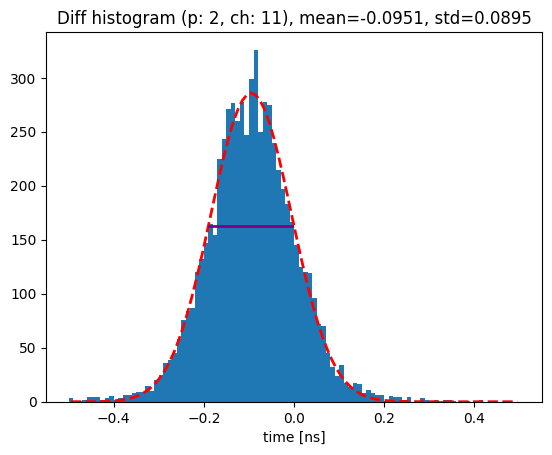

Covariance matrix of the Gaussian fit:
[[ 9.55995158e+00  6.67777804e-11 -1.99605238e-03]
 [ 6.67777804e-11  1.25028607e-06 -2.96229247e-14]
 [-1.99605238e-03 -2.96229247e-14  1.25028614e-06]]


In [16]:
std_cfd_hist, pcov, fwhm_cfd = plot_difference_hist(y_test, y_pred, PLANE, CHANNEL, print_pcov=PRINT_PCOV)
std_cfd_stat = np.std(y_pred - y_test)

# MLP 1

In [17]:
mlp_1_name = model_name = 'MLP 1'
model = keras.Sequential([
    layers.Input(24),
    layers.Dense(1)
])

history = train_model(model, model_name, lr=0.1, train=False, n_epochs=3000, lr_patience=50, es_patience=200, loss_weights=1000)

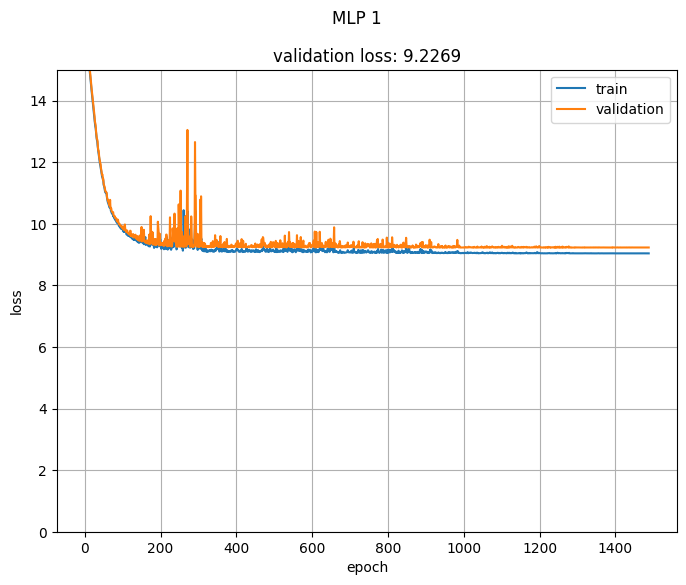

In [18]:
plot_history(history, model_name, ymax=15)

205/205 [==============================] - 1s 809us/step


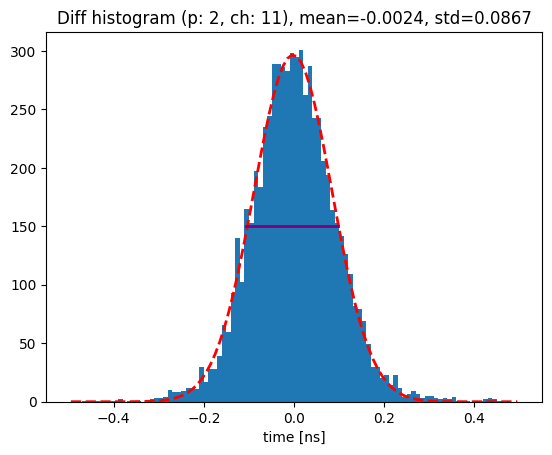

Covariance matrix of the Gaussian fit:
[[ 7.11616502e+00  5.97778758e-11 -1.38697068e-03]
 [ 5.97778758e-11  8.10979366e-07  7.22900028e-15]
 [-1.38697068e-03  7.22900028e-15  8.10979375e-07]]


In [19]:
y_pred = model.predict(X_test)[:, 0]
std_1_hist, pcov, fwhm_1 = plot_difference_hist(y_test, y_pred, PLANE, CHANNEL, print_pcov=PRINT_PCOV)
std_1_stat = np.std(y_pred - y_test)

# MLP 2

In [20]:
mlp_2_name = model_name = 'MLP 2'
model = keras.Sequential([
    layers.Input(24),
    
    layers.Dense(24, activation='relu'),
    layers.Dense(12, activation='relu'),
    layers.Dense(6, activation='relu'),
    layers.Dense(1)
])

history = train_model(model, model_name, lr=0.01, train=False, n_epochs=3000, lr_patience=50, es_patience=400, loss_weights=1000)

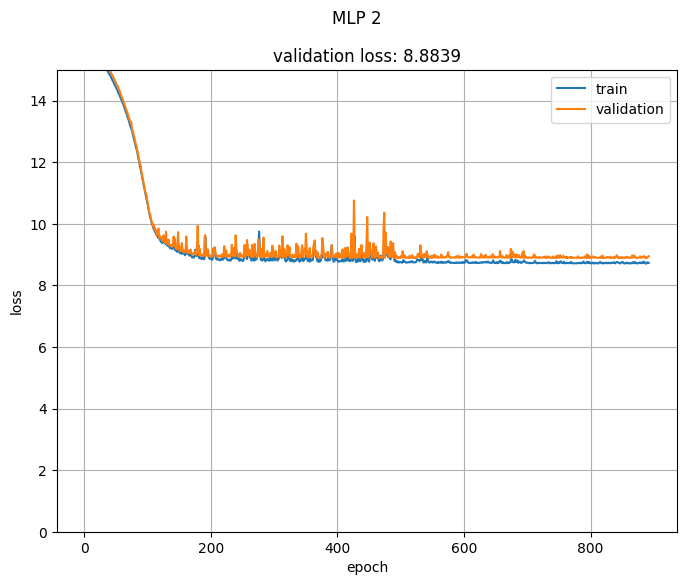

In [21]:
plot_history(history, model_name, ymax=15)

205/205 [==============================] - 0s 985us/step


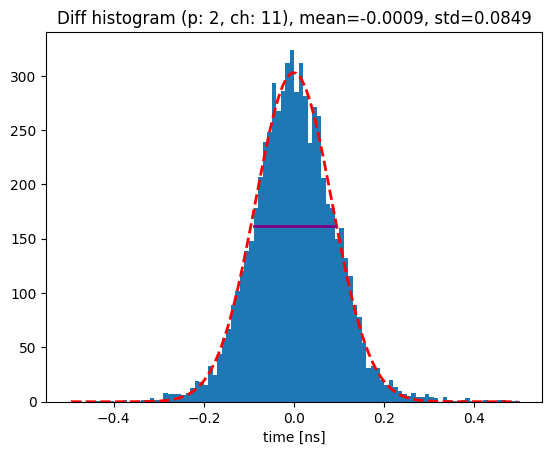

Covariance matrix of the Gaussian fit:
[[ 7.54847469e+00 -1.35585838e-10 -1.41025533e-03]
 [-1.35585838e-10  7.90419384e-07 -7.64108044e-14]
 [-1.41025533e-03 -7.64108044e-14  7.90419332e-07]]


In [22]:
y_pred = model.predict(X_test)[:, 0]
std_2_hist, pcov, fwhm_2 = plot_difference_hist(y_test, y_pred, PLANE, CHANNEL, print_pcov=PRINT_PCOV)
std_2_stat = np.std(y_pred - y_test)

# Convolutional network 1

In [23]:
cnn_1_name = model_name = 'CNN 1'
model = keras.Sequential([
    layers.Input(24),
    layers.Reshape((-1, 1)),
    
    layers.Conv1D(16, 3, padding='same', activation='relu'),
    
    layers.Flatten(),
    layers.Dense(1)
])

history = train_model(model, model_name, lr=0.01, train=False, n_epochs=3000, lr_patience=50, es_patience=200, loss_weights=1000)

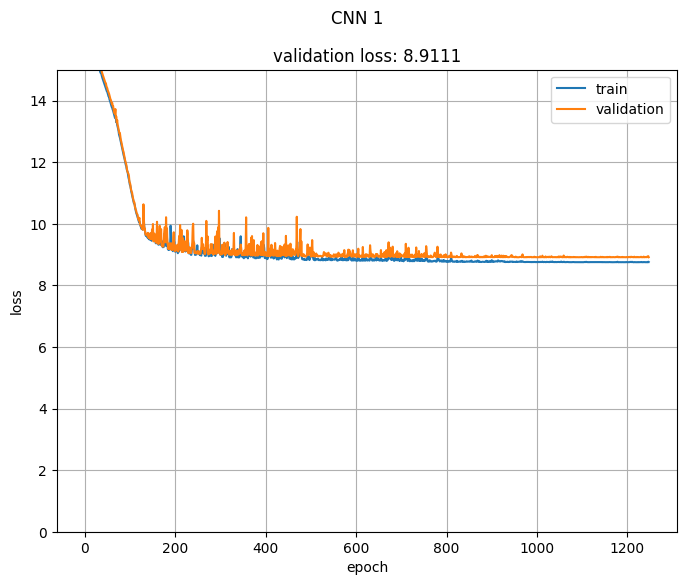

In [24]:
plot_history(history, model_name, ymax=15)

205/205 [==============================] - 2s 1ms/step


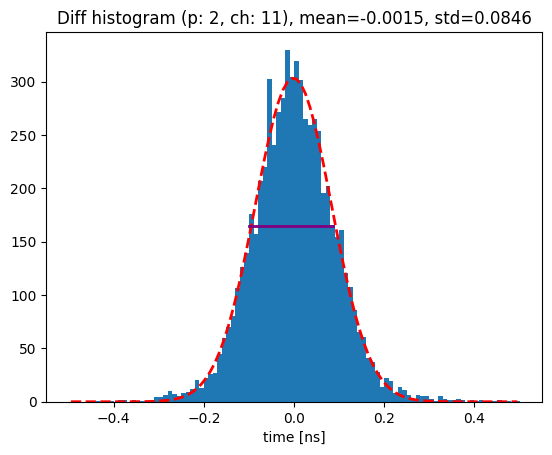

Covariance matrix of the Gaussian fit:
[[ 9.81656230e+00  5.04255322e-10 -1.82628021e-03]
 [ 5.04255322e-10  1.01928735e-06 -9.81406112e-14]
 [-1.82628021e-03 -9.81406112e-14  1.01928741e-06]]


In [25]:
y_pred = model.predict(X_test)[:, 0]
std_3_hist, pcov, fwhm_3 = plot_difference_hist(y_test, y_pred, PLANE, CHANNEL, print_pcov=PRINT_PCOV)
std_3_stat = np.std(y_pred - y_test)

# Convolutional network 2

In [26]:
cnn_2_name = model_name = 'CNN 2'
model = keras.Sequential([
    layers.Input(24),
    layers.Reshape((-1, 1)),
    
    layers.Conv1D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling1D(),
    
    layers.Conv1D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling1D(),
    
    layers.Conv1D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling1D(),
    
    layers.Flatten(),
    layers.Dense(1)
])

history = train_model(model, model_name, lr=0.01, train=False, n_epochs=3000, lr_patience=50, es_patience=400, loss_weights=1000)

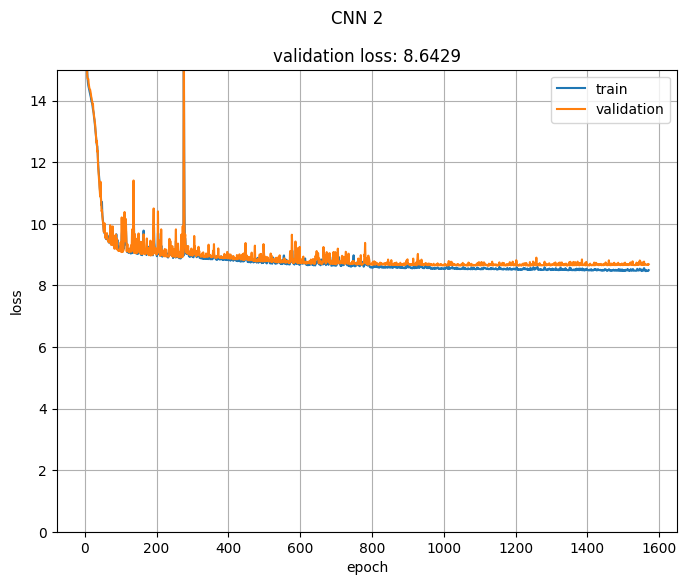

In [27]:
plot_history(history, model_name, ymax=15)

205/205 [==============================] - 0s 1ms/step


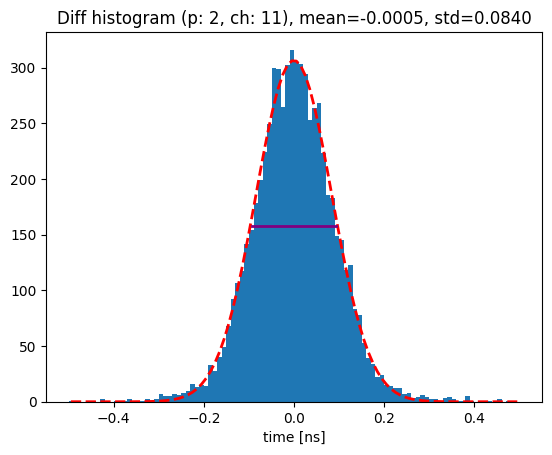

Covariance matrix of the Gaussian fit:
[[ 5.90207318e+00 -8.02334915e-10 -1.08054166e-03]
 [-8.02334915e-10  5.93470126e-07  2.19006788e-14]
 [-1.08054166e-03  2.19006788e-14  5.93471268e-07]]


In [28]:
y_pred = model.predict(X_test)[:, 0]
std_4_hist, pcov, fwhm_4 = plot_difference_hist(y_test, y_pred, PLANE, CHANNEL, print_pcov=PRINT_PCOV)
std_4_stat = np.std(y_pred - y_test)

# UNet

In [29]:
def gaussian_kernel(mu, sigma=1., n=24):
    x = np.arange(0, n)
    return np.exp(-(x - mu)**2 / (2 * sigma**2))

get_gauss_stats(np.arange(24), gaussian_kernel(np.array(1.6)))[0]

1.0

In [30]:
Y_heatmap_train = np.array([gaussian_kernel(y) for y in y_train])
Y_heatmap_test = np.array([gaussian_kernel(y) for y in y_test])

In [31]:
unet_name = model_name = 'UNet'

def conv_block(x, n_filters):
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    skip = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D()(skip)
    return skip, x
    
def deconv_block(x, skip, n_filters):
    x = layers.UpSampling1D()(x)
    x = layers.Conv1D(n_filters, 1, activation='linear')(x)
    x = layers.Concatenate()([skip, x])
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    return x
    
    
###################################

inputs = layers.Input(24)
x = layers.Reshape((-1, 1))(inputs)

skip1, x = conv_block(x, 64)
skip2, x = conv_block(x, 128)
skip3, x = conv_block(x, 256)
x, _ = conv_block(x, 512)

x = deconv_block(x, skip3, 256)
x = deconv_block(x, skip2, 128)
x = deconv_block(x, skip1, 64)

x = layers.Conv1D(1, 1, activation='linear')(x)

outputs = layers.Flatten()(x)

model = tf.keras.Model(inputs, outputs)

#############################################

history = train_model(model, model_name, y_train=Y_heatmap_train, y_val=Y_heatmap_test, lr=0.0005, train=False, n_epochs=3000, lr_patience=50, es_patience=300, loss_weights=10000)

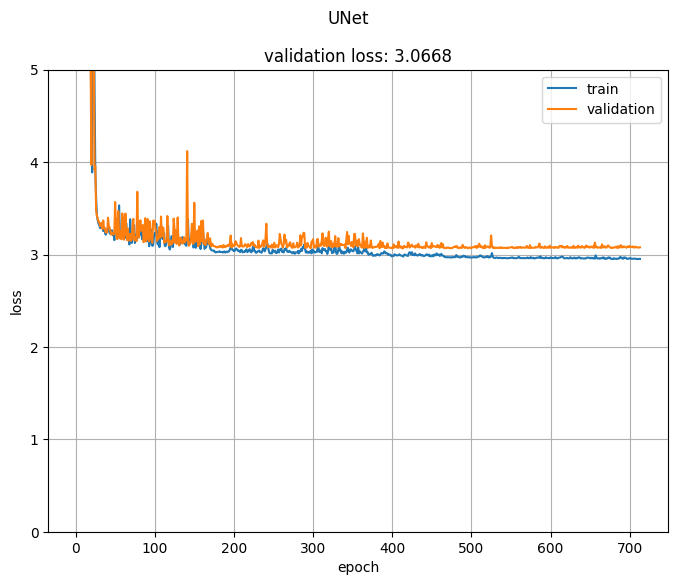

In [32]:
plot_history(history, model_name, ymax=5)

205/205 [==============================] - 1s 4ms/step


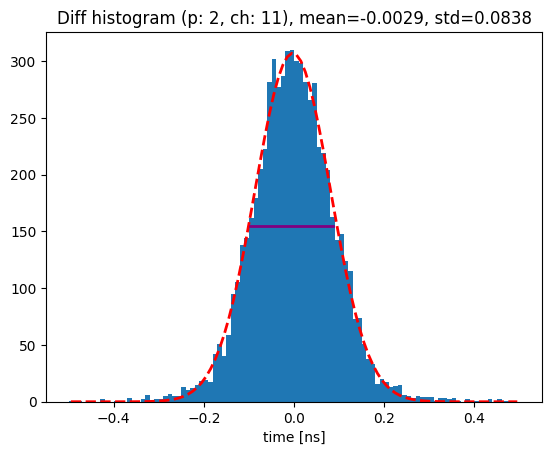

Covariance matrix of the Gaussian fit:
[[ 6.22975712e+00 -9.69855665e-11 -1.13469556e-03]
 [-9.69855665e-11  6.20024421e-07  1.08126470e-14]
 [-1.13469556e-03  1.08126470e-14  6.20024516e-07]]


In [33]:
Y_heatmap_pred = model.predict(X_test)

y_pred = np.empty(Y_heatmap_pred.shape[0])
for i, y in enumerate(Y_heatmap_pred):
    _, y_pred[i], _, _ = get_gauss_stats(np.arange(24), y, a_0=1, std_0=1.)

std_5_hist, pcov, fwhm_5 = plot_difference_hist(y_test, y_pred, PLANE, CHANNEL, print_pcov=PRINT_PCOV)
std_5_stat = np.std(y_pred - y_test)

# RNN

In [34]:
rnn_name = model_name = 'RNN'
model = keras.Sequential([
    layers.Input(24),
    layers.Reshape((-1, 1)),
    
    layers.LSTM(512),
    
    layers.Dense(1)
])

history = train_model(model, model_name, lr=0.005, train=False, n_epochs=3000, lr_patience=50, es_patience=200, loss_weights=1000)

In [35]:
# model.summary()

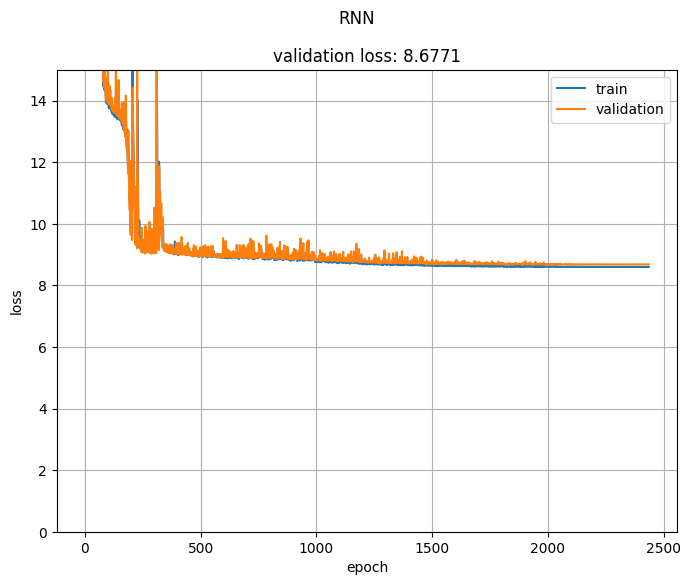

In [36]:
plot_history(history, model_name, ymax=15)

205/205 [==============================] - 1s 3ms/step


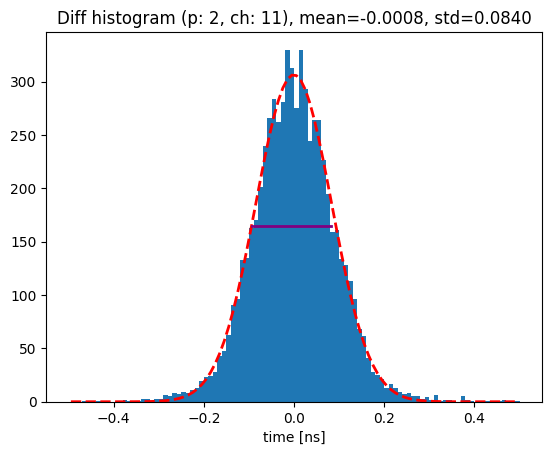

Covariance matrix of the Gaussian fit:
[[ 8.10681748e+00 -6.75340162e-11 -1.48269651e-03]
 [-6.75340162e-11  8.13532331e-07  1.04997478e-13]
 [-1.48269651e-03  1.04997478e-13  8.13533412e-07]]


In [37]:
y_pred = model.predict(X_test)[:, 0]
std_6_hist, pcov, fwhm_6 = plot_difference_hist(y_test, y_pred, PLANE, CHANNEL, print_pcov=PRINT_PCOV)
std_6_stat = np.std(y_pred - y_test)

# Compare standard deviations

In [38]:
def compare_stds(std_cfd, stds, names):
    print(f"{'CFD':>10}: {std_cfd * 1000:0.2f} ps")
    for i, (std, name) in enumerate(sorted(zip(stds, names))):
        print(f"{name:>10}: {std * 1000:0.2f} ps (improvement: {(1 - std / std_cfd) * 100:0.2f} %)")

### Difference histogram – Gauss

In [39]:
compare_stds(std_cfd_hist, [std_1_hist, std_2_hist, std_3_hist, std_4_hist, std_5_hist, std_6_hist], [mlp_1_name, mlp_2_name, cnn_1_name, cnn_2_name, unet_name, rnn_name])

       CFD: 89.52 ps
      UNet: 83.84 ps (improvement: 6.34 %)
       RNN: 83.99 ps (improvement: 6.17 %)
     CNN 2: 84.04 ps (improvement: 6.12 %)
     CNN 1: 84.62 ps (improvement: 5.47 %)
     MLP 2: 84.86 ps (improvement: 5.20 %)
     MLP 1: 86.66 ps (improvement: 3.20 %)


### Stat

In [40]:
compare_stds(std_cfd_stat, [std_1_stat, std_2_stat, std_3_stat, std_4_stat, std_5_stat, std_6_stat], [mlp_1_name, mlp_2_name, cnn_1_name, cnn_2_name, unet_name, rnn_name])

       CFD: 100.84 ps
      UNet: 92.81 ps (improvement: 7.96 %)
     CNN 2: 92.97 ps (improvement: 7.81 %)
       RNN: 93.15 ps (improvement: 7.63 %)
     MLP 2: 94.25 ps (improvement: 6.54 %)
     CNN 1: 94.40 ps (improvement: 6.39 %)
     MLP 1: 96.06 ps (improvement: 4.75 %)


### Full width at half maximum (FWHM)

In [41]:
compare_stds(fwhm_cfd, [fwhm_1, fwhm_2, fwhm_3, fwhm_4, fwhm_5, fwhm_6], [mlp_1_name, mlp_2_name, cnn_1_name, cnn_2_name, unet_name, rnn_name])

       CFD: 185.12 ps
       RNN: 176.12 ps (improvement: 4.86 %)
     MLP 2: 179.72 ps (improvement: 2.92 %)
     CNN 1: 184.52 ps (improvement: 0.32 %)
     CNN 2: 184.82 ps (improvement: 0.16 %)
      UNet: 185.62 ps (improvement: -0.27 %)
     MLP 1: 205.62 ps (improvement: -11.08 %)
